In [1]:
# notebooks/final_comparison.ipynb

In [20]:
# imports and helpers
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from helpers.visualization_helpers import plot_confusion_matrix
from tensorflow.keras.models import load_model

from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier

In [21]:
custom_palette = [
    '#1E4436',  
    '#35AF8A',  
    '#32D99C',  #  middle shade (TA colors)
    '#23FEAE',  
    '#C1FFE8']

In [4]:
y_test = joblib.load('../outputs/models/y_test.joblib')

X_test_bow = joblib.load('../outputs/models/X_test_BOW.joblib')
X_test_tfidf = joblib.load('../outputs/models/X_test_TFIDF.joblib')
X_test_spacy= joblib.load('../outputs/models/X_test_Spacy.joblib')

In [ ]:
# paths to models for each embedding technique
model_paths = {
    'TFIDF': {
        'Random Forest': '../outputs/models/Random_Forest_TFIDF.joblib',
        'Neural Network': '../outputs/models/Neural_Network_TFIDF.keras'
    },
    'BOW': {
        'Random Forest': '../outputs/models/Random_Forest_BOW.joblib',
        'Neural Network': '../outputs/models/Neural_Network_BOW.keras'
    },
    'SpaCy': {
        'Random Forest': '../outputs/models/Random_Forest_SPACY.joblib',
        'Neural Network': '../outputs/models/Neural_Network_SPACY.keras'
    }
}

results = {}  # store results 
# go though all embedding techniques and evaluate 
for vectorization, models in model_paths.items():
    for model_name, model_path in models.items():
        print(f"Evaluating {model_name} with {vectorization} embeddings...")

        try:
            # load model
            if 'Neural Network' in model_name:
                model = load_model(model_path)

                # Use test data for that vectorization 
                if vectorization == 'TFIDF':
                    X_test_dense = X_test_tfidf.toarray()
                elif vectorization == 'BOW':
                    X_test_dense = X_test_bow.toarray()
                else:
                    X_test_dense = X_test_spacy

                # NN preds
                y_pred_probs = model.predict(X_test_dense)
                y_pred = np.argmax(y_pred_probs, axis=1) + 1  # Adjust labels back to 1-5
            else:
                model = joblib.load(model_path)

                # make sure the Random forest is valid and has trees
                if isinstance(model, RandomForestClassifier) and not hasattr(model, 'estimators_'):
                    raise ValueError(f"Random Forest model at {model_path} is not properly loaded or trained.")

                # Use RF test data
                if vectorization == 'TFIDF':
                    X_test = X_test_tfidf
                elif vectorization == 'BOW':
                    X_test = X_test_bow
                else:
                    X_test = X_test_spacy

                y_pred = model.predict(X_test)

            # calculate metrics
            accuracy = accuracy_score(y_test, y_pred)
            precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
            results[(vectorization, model_name)] = {
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1-Score': f1
            }

        except Exception as e:
            print(f"Error evaluating {model_name} with {vectorization}: {e}")
            continue

# print results
for key, metrics in results.items():
    print(f"\nModel: {key[1]} - Embedding: {key[0]}")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")


Evaluating Random Forest with TFIDF embeddings...
Evaluating Neural Network with TFIDF embeddings...
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Evaluating Random Forest with BOW embeddings...
Evaluating Neural Network with BOW embeddings...
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Evaluating Random Forest with SpaCy embeddings...
Evaluating Neural Network with SpaCy embeddings...
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Model: Random Forest - Embedding: TFIDF
  Accuracy: 0.5484
  Precision: 0.5153
  Recall: 0.5484
  F1-Score: 0.5187

Model: Neural Network - Embedding: TFIDF
  Accuracy: 0.5618
  Precision: 0.5520
  Recall: 0.5618
  F1-Score: 0.5558

Model: Random Forest - Embedding: BOW
  Accuracy: 0.5423
  Precision: 0.5035
  Recall: 0.5423
  F1-Score: 0.4979

Model: Neural Network - Embedding: BOW
  Accuracy: 0.6184
  Precision: 0.6097
  Recall: 0.6184
  F1-Score: 0.6118

Model: Random Forest - Embedding: SpaCy
  Accuracy: 0.5221
  Precision: 0.5156
  Recall: 0.5221
  F1-Score: 0.5170


In [16]:
# Create a DataFrame from results
results_df = pd.DataFrame(results).T
print("\nModel Performance Comparison:")
print(results_df)

# Save comparison table
results_df.to_csv('../outputs/models/model_comparison_metrics.csv')
print("\nModel comparison metrics saved successfully.")

# Prepare data for visualization
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
results_df.reset_index(inplace=True)
results_df = results_df.rename(columns={'level_0': 'Vectorization', 'level_1': 'Model'})

# Melt the DataFrame for seaborn visualization
results_melted = results_df.melt(id_vars=['Vectorization', 'Model'], value_vars=metrics, var_name='Metric', value_name='Score')



Model Performance Comparison:
                      Accuracy  Precision    Recall  F1-Score
TFIDF Random Forest   0.548426   0.515267  0.548426  0.518659
      Neural Network  0.561844   0.552042  0.561844  0.555756
BOW   Random Forest   0.542327   0.503527  0.542327  0.497869
      Neural Network  0.618444   0.609714  0.618444  0.611820
SpaCy Random Forest   0.522079   0.515592  0.522079  0.517003
      Neural Network  0.555989   0.565313  0.555989  0.557556

Model comparison metrics saved successfully.


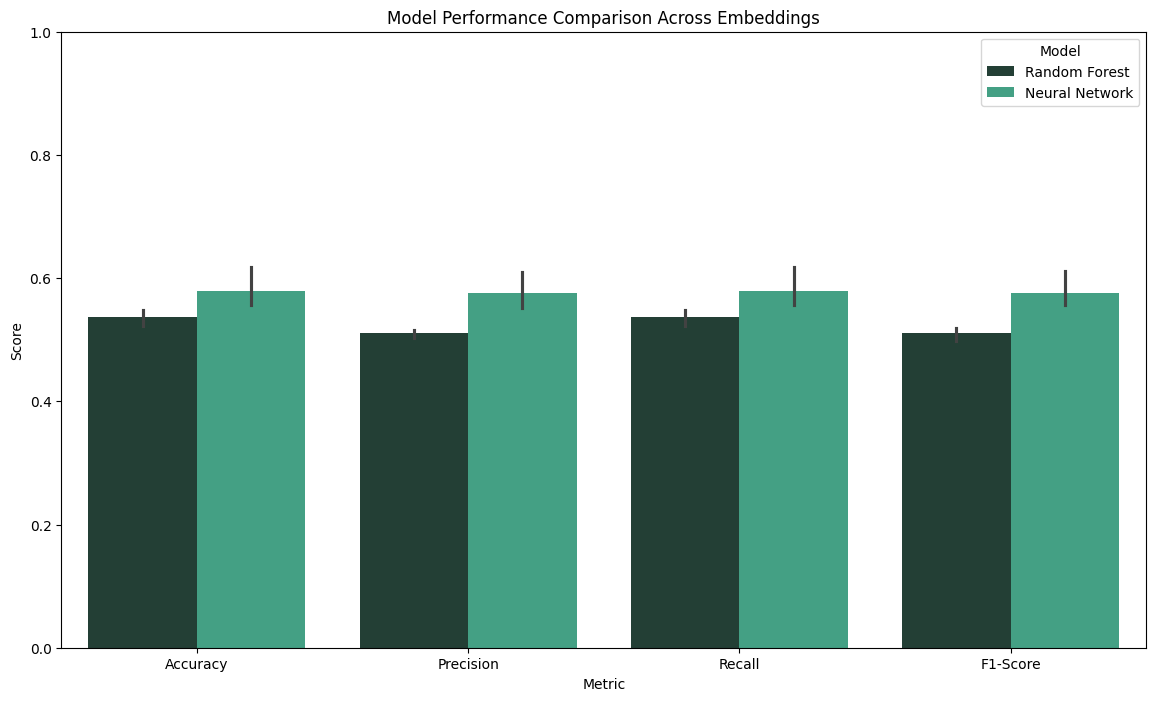

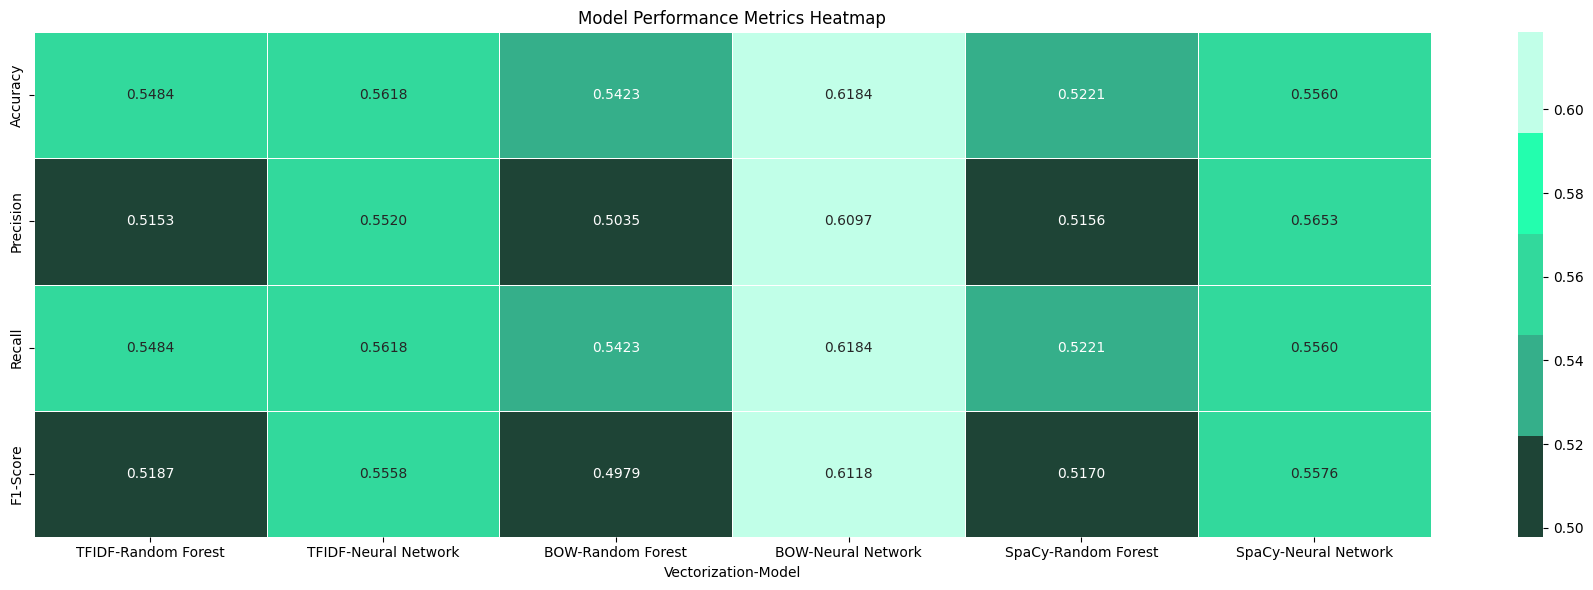

In [22]:
# plot model performance comparison bar chart
plt.figure(figsize=(14, 8))
sns.barplot(x='Metric', y='Score', hue='Model', data=results_melted, palette=custom_palette[0:2])
plt.title("Model Performance Comparison Across Embeddings")
plt.ylim(0, 1)
plt.legend(title='Model')
plt.savefig('../outputs/figures/model_performance_comparison.png')
plt.show()

# heatmap of performace
plt.figure(figsize=(18, 6))
sns.heatmap(results_df.set_index(['Vectorization', 'Model']).T, annot=True, cmap=custom_palette, fmt=".4f", linewidths=0.5)
plt.title("Model Performance Metrics Heatmap")
plt.tight_layout()
plt.show()